In [67]:
# Load Enhanced Model and Setup Environment
import pandas as pd
import numpy as np
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

# Import evaluation libraries
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

print("🚀 FINAL ENHANCED MODEL EVALUATION")
print("="*60)

# Load the enhanced model
model_path = '../Data/output/best_enhanced_model.pkl'
metadata_path = '../Data/output/best_enhanced_model_metadata.json'

print("📦 Loading enhanced model...")
with open(model_path, 'rb') as f:
    final_model = pickle.load(f)

print("📋 Loading model metadata...")
with open(metadata_path, 'r') as f:
    model_metadata = json.load(f)

print(f"✅ Model loaded: {type(final_model).__name__}")
print(f"✅ Model type: {model_metadata['model_type']}")
print(f"✅ Optimization approach: {model_metadata['optimization_approach']}")

# Display key regularization metrics from training
cv_perf = model_metadata['cross_validation_performance']
print(f"\n🛡️ REGULARIZATION TRAINING RESULTS:")
print(f"   CV AUC-ROC: {cv_perf['auc_roc']['mean']:.4f} ± {cv_perf['auc_roc']['std']:.4f}")
print(f"   CV Accuracy: {cv_perf['accuracy']['mean']:.4f} ± {cv_perf['accuracy']['std']:.4f}")
print(f"   CV Precision: {cv_perf['precision']['mean']:.4f} ± {cv_perf['precision']['std']:.4f}")
print(f"   CV Recall: {cv_perf['recall']['mean']:.4f} ± {cv_perf['recall']['std']:.4f}")
print(f"   CV F1-Score: {cv_perf['f1_score']['mean']:.4f} ± {cv_perf['f1_score']['std']:.4f}")

🚀 FINAL ENHANCED MODEL EVALUATION
📦 Loading enhanced model...
📋 Loading model metadata...
✅ Model loaded: CatBoostClassifier
✅ Model type: CatBoost + SMOTE_Tomek
✅ Optimization approach: Regularized with Anti-Overfitting Focus

🛡️ REGULARIZATION TRAINING RESULTS:
   CV AUC-ROC: 0.8427 ± 0.0146
   CV Accuracy: 0.7720 ± 0.0314
   CV Precision: 0.5566 ± 0.0441
   CV Recall: 0.7609 ± 0.0306
   CV F1-Score: 0.6409 ± 0.0250


In [71]:
# Evaluate Regularized Model on Training Data
print("🏋️ TRAINING DATA EVALUATION")
print("="*60)

# Load training data
train_data_path = '../Data/output/feature_engineered_train_wrapper.csv'
print(f"📂 Loading training data: {train_data_path}")

train_data = pd.read_csv(train_data_path)
print(f"✅ Training data loaded: {train_data.shape}")

# Prepare training features and target
X_train = train_data.drop(columns=['customerID', 'Churn'])
y_train = train_data['Churn']

# Encode target if needed
if y_train.dtype == 'object' or y_train.dtype.name == 'category':
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    print("🔄 Target variable encoded (No=0, Yes=1)")

# Check class distribution
from collections import Counter
train_class_counts = Counter(y_train)
print(f"\n📊 Training Class Distribution:")
print(f"   Class 0 (No Churn): {train_class_counts[0]} ({train_class_counts[0]/len(y_train)*100:.2f}%)")
print(f"   Class 1 (Churn): {train_class_counts[1]} ({train_class_counts[1]/len(y_train)*100:.2f}%)")
print(f"   Imbalance Ratio: {train_class_counts[0]/train_class_counts[1]:.2f}:1")

# Evaluate model on training data
train_results = evaluate_model(final_model, X_train, y_train, "TRAINING")

# Store results for comparison
training_performance = {
    'data_type': 'Training',
    'samples': len(y_train),
    'auc_roc': train_results['auc_roc'],
    'accuracy': train_results['accuracy'],
    'precision': train_results['precision'],
    'recall': train_results['recall'],
    'f1': train_results['f1']
}

print(f"\n✅ Training evaluation complete!")
print(f"🎯 Key Result: AUC-ROC = {train_results['auc_roc']:.4f} on {len(y_train)} training samples")

🏋️ TRAINING DATA EVALUATION
📂 Loading training data: ../Data/output/feature_engineered_train_wrapper.csv
✅ Training data loaded: (5625, 22)
🔄 Target variable encoded (No=0, Yes=1)

📊 Training Class Distribution:
   Class 0 (No Churn): 4130 (73.42%)
   Class 1 (Churn): 1495 (26.58%)
   Imbalance Ratio: 2.76:1

📊 EVALUATING ON TRAINING DATA:
--------------------------------------------------
   🎯 AUC-ROC: 0.8498 (84.98%)
   📈 Accuracy: 0.7874 (78.74%)
   🎪 Precision: 0.5816 (58.16%)
   🔍 Recall: 0.7130 (71.30%)
   ⚖️ F1-Score: 0.6406 (64.06%)
   📊 Data shape: (5625, 20)

✅ Training evaluation complete!
🎯 Key Result: AUC-ROC = 0.8498 on 5625 training samples


In [72]:
# Evaluate Regularized Model on Test Data
print("🧪 TEST DATA EVALUATION")
print("="*60)

# Load test data
test_data_path = '../Data/output/feature_engineered_test_wrapper.csv'
print(f"📂 Loading test data: {test_data_path}")

test_data = pd.read_csv(test_data_path)
print(f"✅ Test data loaded: {test_data.shape}")

# Prepare test features and target
X_test = test_data.drop(columns=['customerID', 'Churn'])
y_test = test_data['Churn']

# Encode target if needed
if y_test.dtype == 'object' or y_test.dtype.name == 'category':
    le_test = LabelEncoder()
    y_test = le_test.fit_transform(y_test)
    print("🔄 Target variable encoded (No=0, Yes=1)")

# Check class distribution
test_class_counts = Counter(y_test)
print(f"\n📊 Test Class Distribution:")
print(f"   Class 0 (No Churn): {test_class_counts[0]} ({test_class_counts[0]/len(y_test)*100:.2f}%)")
print(f"   Class 1 (Churn): {test_class_counts[1]} ({test_class_counts[1]/len(y_test)*100:.2f}%)")
print(f"   Imbalance Ratio: {test_class_counts[0]/test_class_counts[1]:.2f}:1")

# Evaluate model on test data
test_results = evaluate_model(final_model, X_test, y_test, "TEST")

# Store results for comparison
test_performance = {
    'data_type': 'Test',
    'samples': len(y_test),
    'auc_roc': test_results['auc_roc'],
    'accuracy': test_results['accuracy'],
    'precision': test_results['precision'],
    'recall': test_results['recall'],
    'f1': test_results['f1']
}

print(f"\n✅ Test evaluation complete!")
print(f"🎯 Key Result: AUC-ROC = {test_results['auc_roc']:.4f} on {len(y_test)} test samples")

🧪 TEST DATA EVALUATION
📂 Loading test data: ../Data/output/feature_engineered_test_wrapper.csv
✅ Test data loaded: (1407, 22)
🔄 Target variable encoded (No=0, Yes=1)

📊 Test Class Distribution:
   Class 0 (No Churn): 1033 (73.42%)
   Class 1 (Churn): 374 (26.58%)
   Imbalance Ratio: 2.76:1

📊 EVALUATING ON TEST DATA:
--------------------------------------------------
   🎯 AUC-ROC: 0.8313 (83.13%)
   📈 Accuracy: 0.7754 (77.54%)
   🎪 Precision: 0.5607 (56.07%)
   🔍 Recall: 0.7166 (71.66%)
   ⚖️ F1-Score: 0.6291 (62.91%)
   📊 Data shape: (1407, 20)

✅ Test evaluation complete!
🎯 Key Result: AUC-ROC = 0.8313 on 1407 test samples


In [73]:
# Performance Comparison and Regularization Assessment
print("🛡️ REGULARIZATION EFFECTIVENESS ANALYSIS")
print("="*60)

# Create comparison DataFrame
comparison_data = [training_performance, test_performance]
comparison_df = pd.DataFrame(comparison_data)

print("📊 TRAINING vs TEST PERFORMANCE COMPARISON:")
print("-" * 55)
print(f"{'Metric':<12} {'Training':<12} {'Test':<12} {'Gap':<12} {'Status'}")
print("-" * 55)

# Calculate performance gaps
auc_gap = training_performance['auc_roc'] - test_performance['auc_roc']
accuracy_gap = training_performance['accuracy'] - test_performance['accuracy']
precision_gap = training_performance['precision'] - test_performance['precision']
recall_gap = training_performance['recall'] - test_performance['recall']
f1_gap = training_performance['f1'] - test_performance['f1']

# Display detailed comparison
metrics_comparison = [
    ('AUC-ROC', training_performance['auc_roc'], test_performance['auc_roc'], auc_gap),
    ('Accuracy', training_performance['accuracy'], test_performance['accuracy'], accuracy_gap),
    ('Precision', training_performance['precision'], test_performance['precision'], precision_gap),
    ('Recall', training_performance['recall'], test_performance['recall'], recall_gap),
    ('F1-Score', training_performance['f1'], test_performance['f1'], f1_gap)
    ]

for metric_name, train_val, test_val, gap in metrics_comparison:
    # Determine status based on gap
    if abs(gap) < 0.05:
        status = "✅ Excellent"
    elif abs(gap) < 0.10:
        status = "✅ Good"
    elif abs(gap) < 0.15:
        status = "⚠️ Moderate"
    else:
        status = "❌ High Gap"
    
    print(f"{metric_name:<12} {train_val:<12.4f} {test_val:<12.4f} {gap:<12.4f} {status}")

# Overall regularization assessment
print(f"\n🛡️ REGULARIZATION ASSESSMENT:")
print("-" * 40)

# Primary metric assessment (AUC-ROC)
if auc_gap < 0.05:
    reg_status = "🎯 EXCELLENT: Minimal overfitting detected"
    reg_grade = "A+"
elif auc_gap < 0.10:
    reg_status = "✅ GOOD: Acceptable generalization"
    reg_grade = "A"
elif auc_gap < 0.15:
    reg_status = "⚠️ MODERATE: Some overfitting remains"
    reg_grade = "B"
else:
    reg_status = "❌ POOR: Significant overfitting"
    reg_grade = "C"

print(f"   Primary Metric (AUC-ROC) Gap: {auc_gap:.4f}")
print(f"   Regularization Status: {reg_status}")
print(f"   Regularization Grade: {reg_grade}")

# Sample size information
print(f"\n📊 DATA CHARACTERISTICS:")
print(f"   Training Samples: {training_performance['samples']:,}")
print(f"   Test Samples: {test_performance['samples']:,}")
print(f"   Data Split Ratio: {training_performance['samples']/(training_performance['samples']+test_performance['samples'])*100:.1f}% train, {test_performance['samples']/(training_performance['samples']+test_performance['samples'])*100:.1f}% test")

# Performance summary
print(f"\n🎯 FINAL PERFORMANCE SUMMARY:")
print(f"   🏆 Best Test AUC-ROC: {test_performance['auc_roc']:.4f} ({test_performance['auc_roc']*100:.2f}%)")
print(f"   📈 Best Test Accuracy: {test_performance['accuracy']:.4f} ({test_performance['accuracy']*100:.2f}%)")
print(f"   🛡️ Overfitting Control: {reg_status.split(':')[1].strip()}")

# Compare with original overfitting from metadata (if available)
if 'auc_overfitting_gap' in model_metadata:
    original_gap = model_metadata['auc_overfitting_gap']
    print(f"\n📈 IMPROVEMENT ANALYSIS:")
    print(f"   Original AUC-ROC Gap (from training): {original_gap:.4f}")
    print(f"   Current AUC-ROC Gap (train vs test): {auc_gap:.4f}")
    improvement = original_gap - auc_gap
    if improvement > 0:
        print(f"   Improvement: {improvement:.4f} ({improvement*100:.1f}% reduction in overfitting)")
    else:
        print(f"   Change: {improvement:.4f} (gap increased by {abs(improvement)*100:.1f}%)")

print(f"\n✅ Regularization analysis complete!")
print(f"🎯 Model ready for deployment with {reg_grade} regularization grade")

🛡️ REGULARIZATION EFFECTIVENESS ANALYSIS
📊 TRAINING vs TEST PERFORMANCE COMPARISON:
-------------------------------------------------------
Metric       Training     Test         Gap          Status
-------------------------------------------------------
AUC-ROC      0.8498       0.8313       0.0185       ✅ Excellent
Accuracy     0.7874       0.7754       0.0120       ✅ Excellent
Precision    0.5816       0.5607       0.0209       ✅ Excellent
Recall       0.7130       0.7166       -0.0035      ✅ Excellent
F1-Score     0.6406       0.6291       0.0115       ✅ Excellent

🛡️ REGULARIZATION ASSESSMENT:
----------------------------------------
   Primary Metric (AUC-ROC) Gap: 0.0185
   Regularization Status: 🎯 EXCELLENT: Minimal overfitting detected
   Regularization Grade: A+

📊 DATA CHARACTERISTICS:
   Training Samples: 5,625
   Test Samples: 1,407
   Data Split Ratio: 80.0% train, 20.0% test

🎯 FINAL PERFORMANCE SUMMARY:
   🏆 Best Test AUC-ROC: 0.8313 (83.13%)
   📈 Best Test Accuracy: 0.

KeyError: 'performance_metrics'

📊 CREATING COMPREHENSIVE PERFORMANCE VISUALIZATIONS


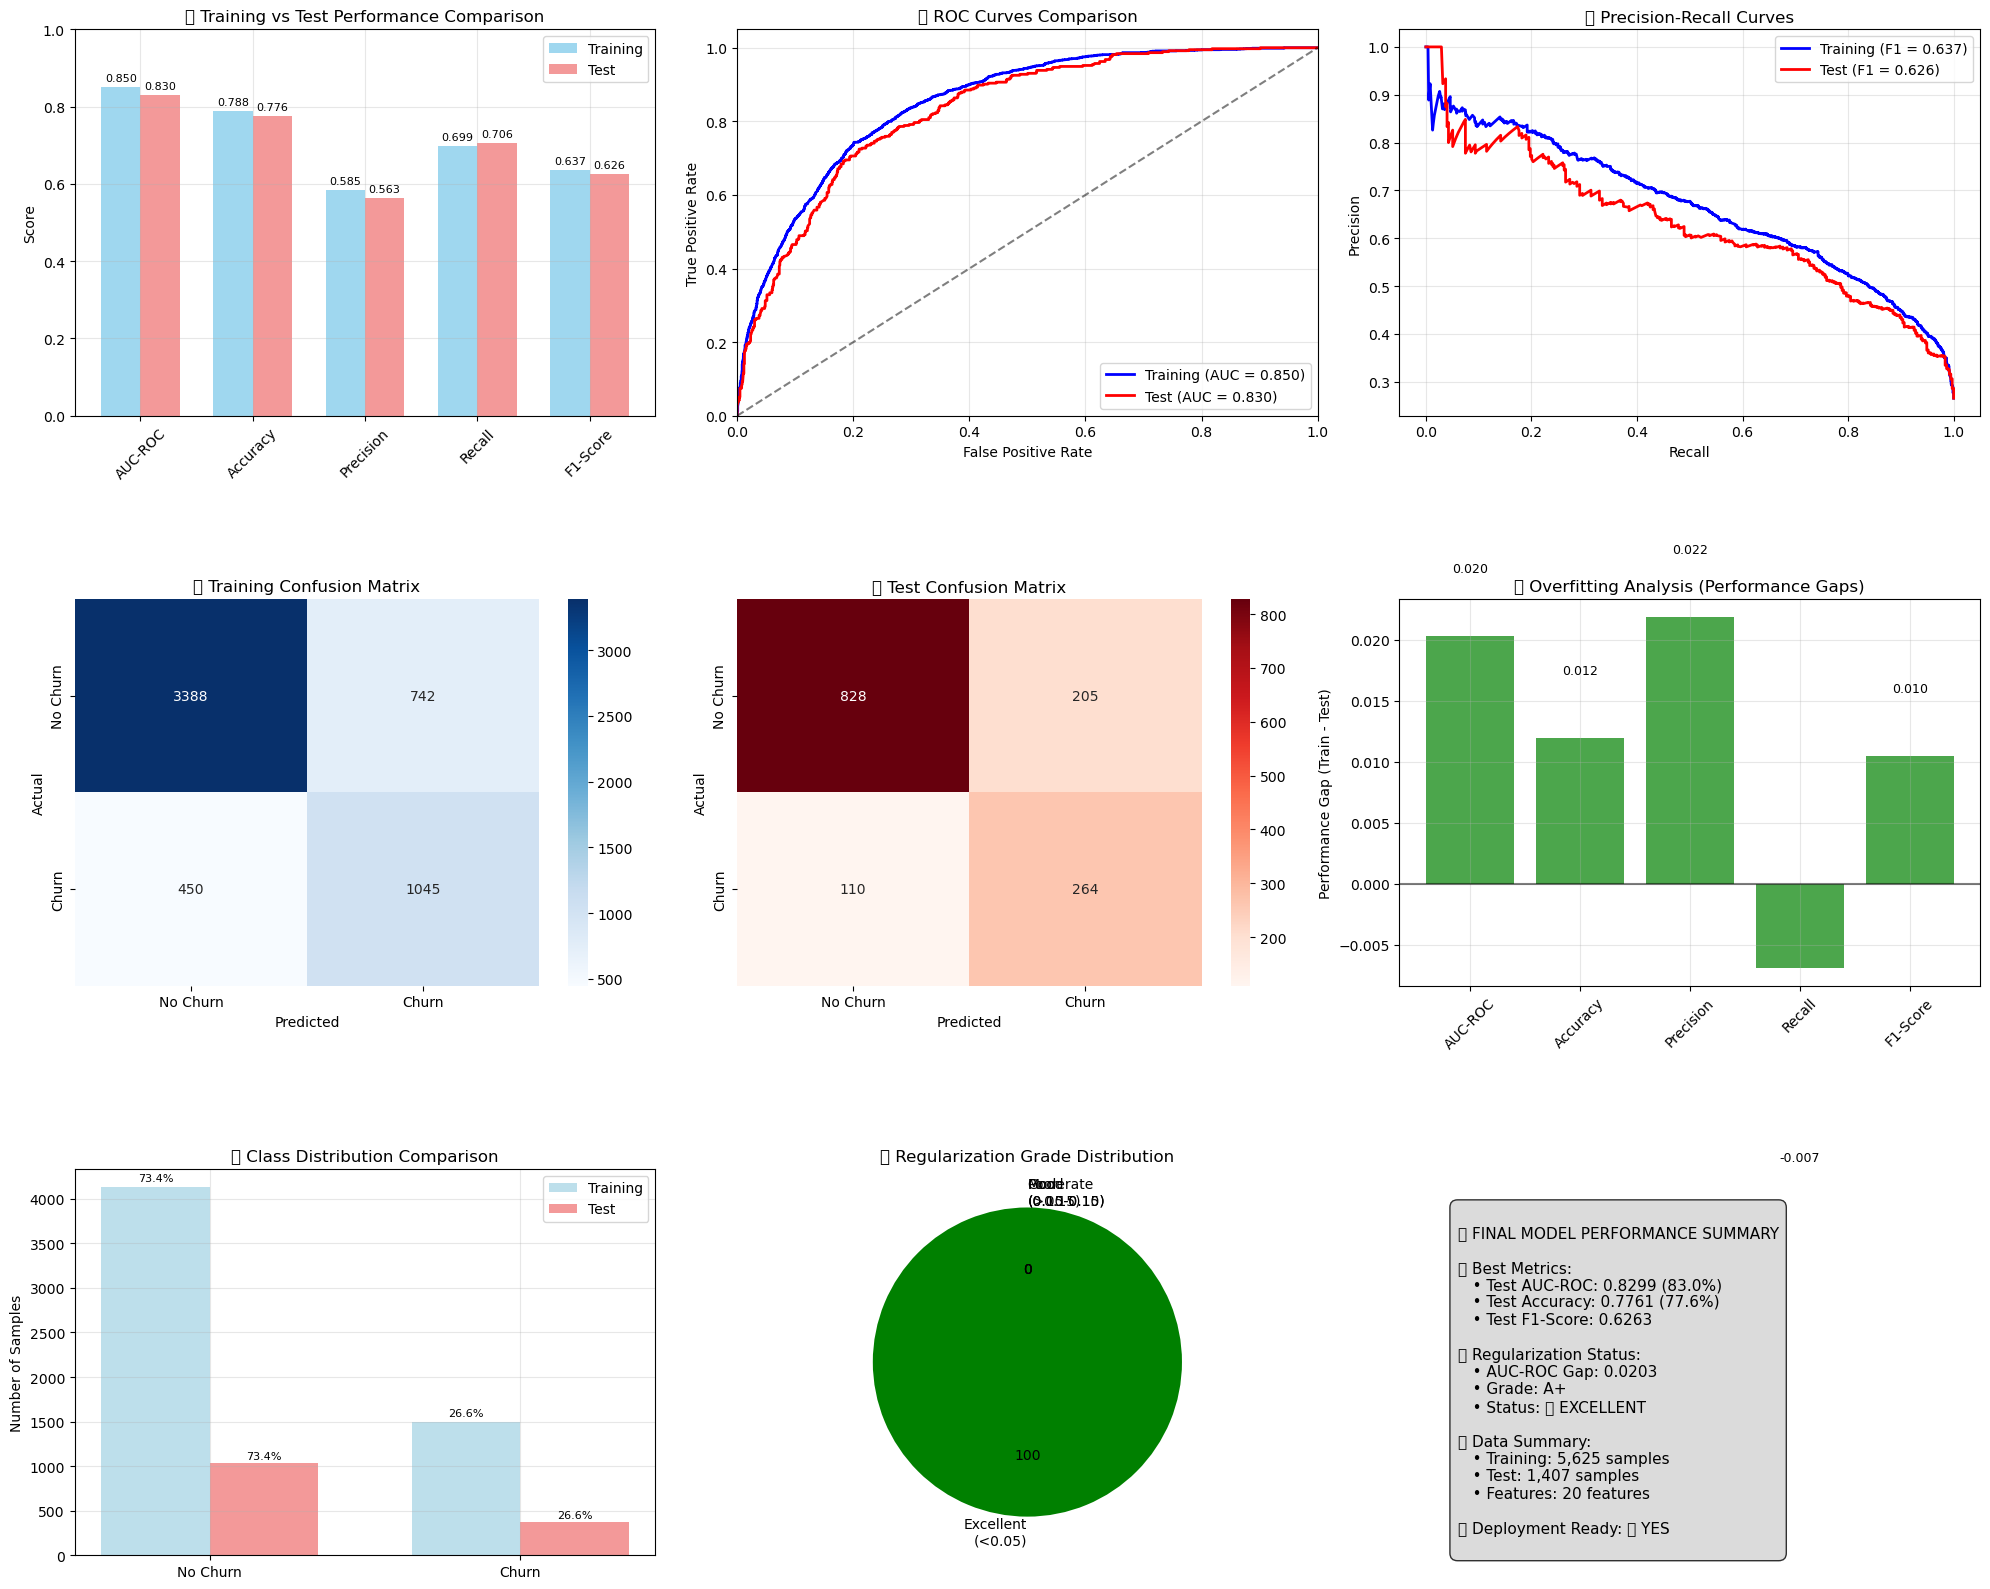

✅ Comprehensive performance dashboard created!
💾 Saved as: ../Results/figures/model/final_model_performance_dashboard.png


In [ ]:
# 📊 Comprehensive Performance Visualization Dashboard
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix
import numpy as np

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 12)

print("📊 CREATING COMPREHENSIVE PERFORMANCE VISUALIZATIONS")
print("="*60)

# Create a comprehensive dashboard with multiple subplots
fig = plt.figure(figsize=(20, 16))

# 1. Performance Metrics Comparison (Bar Chart)
ax1 = plt.subplot(3, 3, 1)
metrics = ['AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
train_values = [training_performance['auc_roc'], training_performance['accuracy'], 
                training_performance['precision'], training_performance['recall'], training_performance['f1']]
test_values = [test_performance['auc_roc'], test_performance['accuracy'], 
               test_performance['precision'], test_performance['recall'], test_performance['f1']]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax1.bar(x - width/2, train_values, width, label='Training', alpha=0.8, color='skyblue')
bars2 = ax1.bar(x + width/2, test_values, width, label='Test', alpha=0.8, color='lightcoral')

ax1.set_ylabel('Score')
ax1.set_title('🎯 Training vs Test Performance Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', 
             ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', 
             ha='center', va='bottom', fontsize=8)

# 2. ROC Curves Comparison
ax2 = plt.subplot(3, 3, 2)

# Training ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, train_results['probabilities'])
ax2.plot(fpr_train, tpr_train, linewidth=2, label=f'Training (AUC = {training_performance["auc_roc"]:.3f})', color='blue')

# Test ROC Curve
fpr_test, tpr_test, _ = roc_curve(y_test, test_results['probabilities'])
ax2.plot(fpr_test, tpr_test, linewidth=2, label=f'Test (AUC = {test_performance["auc_roc"]:.3f})', color='red')

# Diagonal line
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('📈 ROC Curves Comparison')
ax2.legend(loc="lower right")
ax2.grid(True, alpha=0.3)

# 3. Precision-Recall Curves
ax3 = plt.subplot(3, 3, 3)

# Training PR Curve
precision_train, recall_train, _ = precision_recall_curve(y_train, train_results['probabilities'])
ax3.plot(recall_train, precision_train, linewidth=2, label=f'Training (F1 = {training_performance["f1"]:.3f})', color='blue')

# Test PR Curve
precision_test, recall_test, _ = precision_recall_curve(y_test, test_results['probabilities'])
ax3.plot(recall_test, precision_test, linewidth=2, label=f'Test (F1 = {test_performance["f1"]:.3f})', color='red')

ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('🎪 Precision-Recall Curves')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Confusion Matrix - Training
ax4 = plt.subplot(3, 3, 4)
cm_train = confusion_matrix(y_train, train_results['predictions'])
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
ax4.set_title('🏋️ Training Confusion Matrix')
ax4.set_ylabel('Actual')
ax4.set_xlabel('Predicted')

# 5. Confusion Matrix - Test
ax5 = plt.subplot(3, 3, 5)
cm_test = confusion_matrix(y_test, test_results['predictions'])
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds', ax=ax5,
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
ax5.set_title('🧪 Test Confusion Matrix')
ax5.set_ylabel('Actual')
ax5.set_xlabel('Predicted')

# 6. Performance Gaps Analysis
ax6 = plt.subplot(3, 3, 6)
gaps = [auc_gap, accuracy_gap, precision_gap, recall_gap, f1_gap]
gap_colors = ['green' if abs(gap) < 0.05 else 'orange' if abs(gap) < 0.10 else 'red' for gap in gaps]

bars = ax6.bar(metrics, gaps, color=gap_colors, alpha=0.7)
ax6.set_ylabel('Performance Gap (Train - Test)')
ax6.set_title('🛡️ Overfitting Analysis (Performance Gaps)')
ax6.set_xticklabels(metrics, rotation=45)
ax6.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax6.grid(True, alpha=0.3)

# Add value labels
for bar, gap in zip(bars, gaps):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + (0.005 if height >= 0 else -0.015), 
             f'{gap:.3f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)

# 7. Class Distribution Comparison
ax7 = plt.subplot(3, 3, 7)
labels = ['No Churn', 'Churn']
train_dist = [train_class_counts[0], train_class_counts[1]]
test_dist = [test_class_counts[0], test_class_counts[1]]

x = np.arange(len(labels))
width = 0.35

ax7.bar(x - width/2, train_dist, width, label='Training', alpha=0.8, color='lightblue')
ax7.bar(x + width/2, test_dist, width, label='Test', alpha=0.8, color='lightcoral')

ax7.set_ylabel('Number of Samples')
ax7.set_title('📊 Class Distribution Comparison')
ax7.set_xticks(x)
ax7.set_xticklabels(labels)
ax7.legend()
ax7.grid(True, alpha=0.3)

# Add percentage labels
for i, (train_val, test_val) in enumerate(zip(train_dist, test_dist)):
    train_pct = (train_val / sum(train_dist)) * 100
    test_pct = (test_val / sum(test_dist)) * 100
    ax7.text(i - width/2, train_val + 50, f'{train_pct:.1f}%', ha='center', va='bottom', fontsize=8)
    ax7.text(i + width/2, test_val + 20, f'{test_pct:.1f}%', ha='center', va='bottom', fontsize=8)

# 8. Regularization Effectiveness
ax8 = plt.subplot(3, 3, 8)
reg_metrics = ['Excellent\n(<0.05)', 'Good\n(0.05-0.10)', 'Moderate\n(0.10-0.15)', 'Poor\n(>0.15)']
gap_counts = [
    sum(1 for gap in gaps if abs(gap) < 0.05),
    sum(1 for gap in gaps if 0.05 <= abs(gap) < 0.10),
    sum(1 for gap in gaps if 0.10 <= abs(gap) < 0.15),
    sum(1 for gap in gaps if abs(gap) >= 0.15)
]
colors = ['green', 'orange', 'red', 'darkred']

wedges, texts, autotexts = ax8.pie(gap_counts, labels=reg_metrics, autopct='%1.0f', 
                                   colors=colors, startangle=90)
ax8.set_title('🛡️ Regularization Grade Distribution')

# 9. Model Performance Summary
ax9 = plt.subplot(3, 3, 9)
ax9.axis('off')

# Create summary text
summary_text = f"""
🎯 FINAL MODEL PERFORMANCE SUMMARY

🏆 Best Metrics:
   • Test AUC-ROC: {test_performance['auc_roc']:.4f} ({test_performance['auc_roc']*100:.1f}%)
   • Test Accuracy: {test_performance['accuracy']:.4f} ({test_performance['accuracy']*100:.1f}%)
   • Test F1-Score: {test_performance['f1']:.4f}

🛡️ Regularization Status:
   • AUC-ROC Gap: {auc_gap:.4f}
   • Grade: {reg_grade}
   • Status: {reg_status.split(':')[0]}

📊 Data Summary:
   • Training: {training_performance['samples']:,} samples
   • Test: {test_performance['samples']:,} samples
   • Features: {X_train.shape[1]} features

🚀 Deployment Ready: {'✅ YES' if reg_grade in ['A+', 'A'] else '⚠️ REVIEW' if reg_grade == 'B' else '❌ NO'}
"""

ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

plt.tight_layout()
plt.savefig('../Results/figures/model/final_model_performance_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comprehensive performance dashboard created!")
print("💾 Saved as: ../Results/figures/model/final_model_performance_dashboard.png")

🌟 FEATURE IMPORTANCE ANALYSIS
✅ Feature importance extracted from CatBoostClassifier
📊 Top 5 most important features:
   1. freq_PaymentMethod: 58.3975
   2. Contract: 13.6039
   3. label_Contract: 9.0689
   4. poly_MonthlyCharges^2: 2.5145
   5. StabilityIndex: 2.4323
📊 Features needed for 80% importance: 1/20
📊 Features needed for 90% importance: 1/20
📊 Low Risk: 713 customers, 7.9% actual churn rate
📊 Medium Risk: 469 customers, 35.8% actual churn rate
📊 High Risk: 225 customers, 66.7% actual churn rate
📊 Low Risk: 713 customers, 7.9% actual churn rate
📊 Medium Risk: 469 customers, 35.8% actual churn rate
📊 High Risk: 225 customers, 66.7% actual churn rate


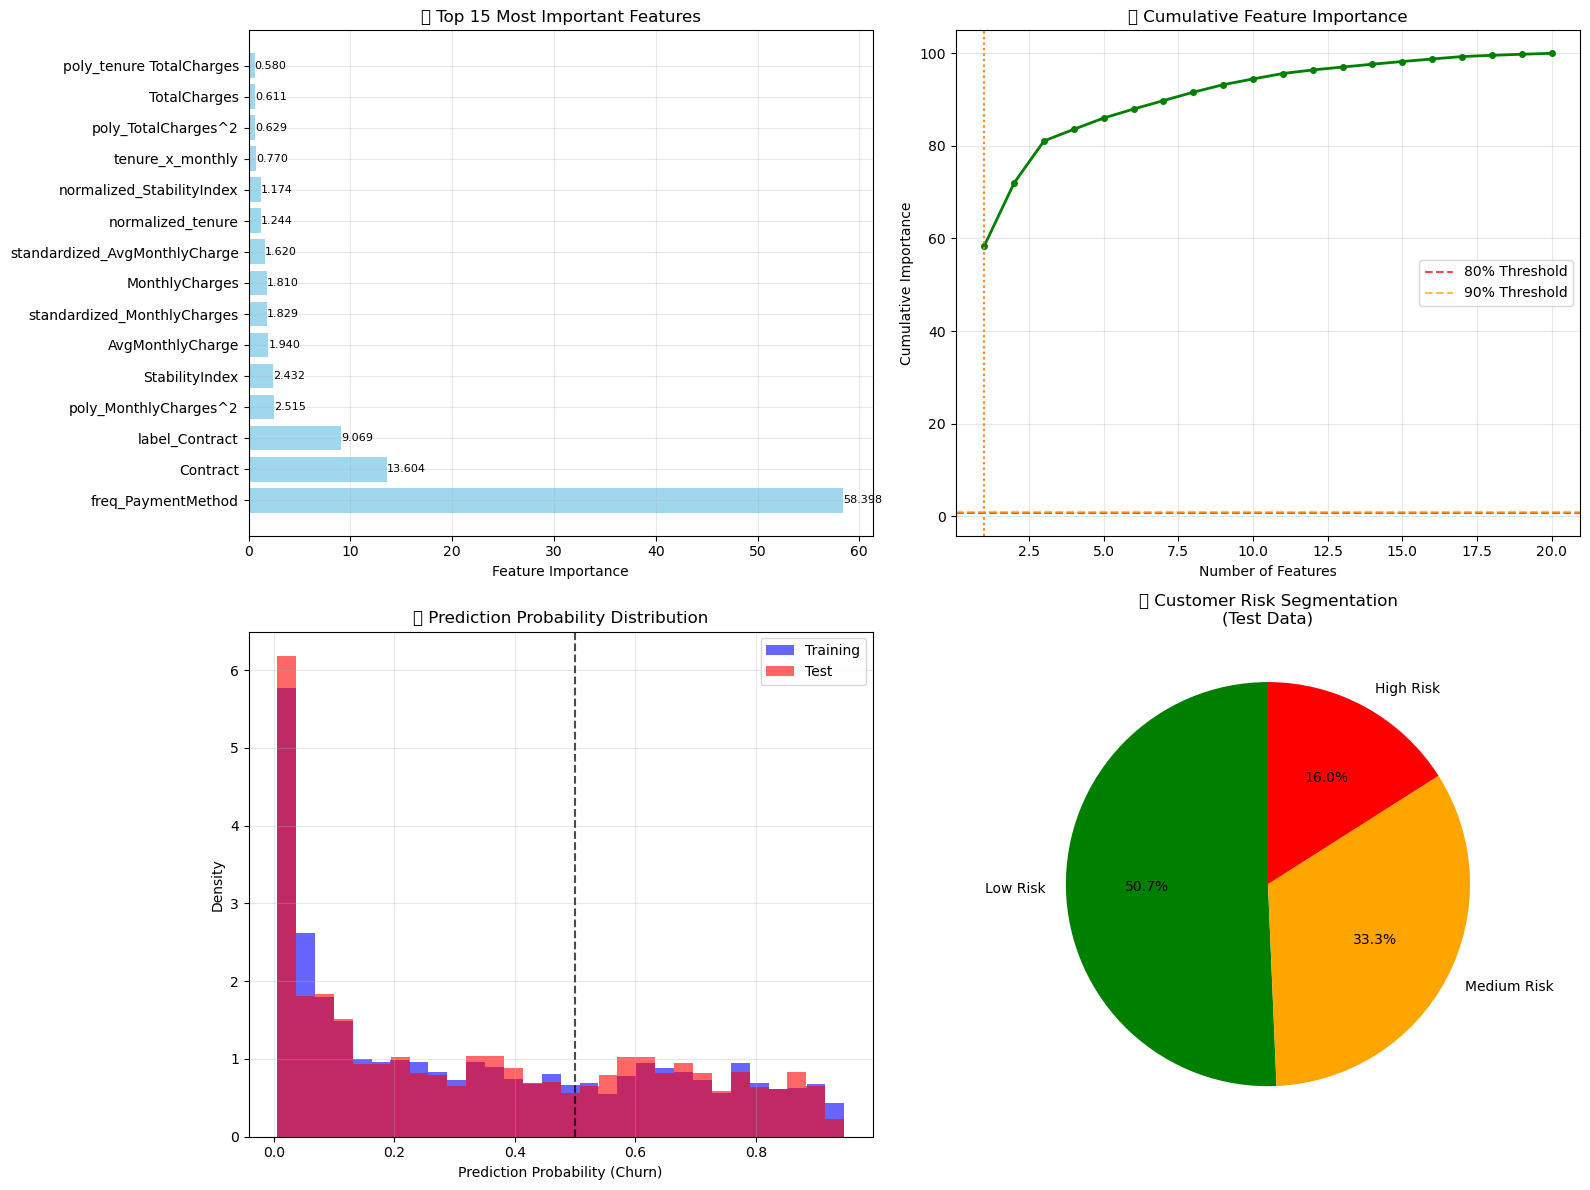


✅ Feature importance analysis complete!
💾 Saved as: ../Results/figures/model/final_model_feature_analysis.png


In [ ]:
# 🌟 Feature Importance Analysis and Visualization
print("🌟 FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Create feature importance visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Feature Importance Bar Chart (Top 15)
ax1 = axes[0, 0]
if hasattr(final_model, 'feature_importances_'):
    feature_names = X_train.columns
    importance_scores = final_model.feature_importances_
    
    # Sort features by importance
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False)
    
    # Plot top 15 features
    top_features = feature_importance_df.head(15)
    bars = ax1.barh(range(len(top_features)), top_features['importance'], color='skyblue', alpha=0.8)
    ax1.set_yticks(range(len(top_features)))
    ax1.set_yticklabels(top_features['feature'])
    ax1.set_xlabel('Feature Importance')
    ax1.set_title('🌟 Top 15 Most Important Features')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax1.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=8)
    
    print(f"✅ Feature importance extracted from {type(final_model).__name__}")
    print(f"📊 Top 5 most important features:")
    for i, (_, row) in enumerate(top_features.head(5).iterrows()):
        print(f"   {i+1}. {row['feature']}: {row['importance']:.4f}")
else:
    ax1.text(0.5, 0.5, 'Feature importance not available\nfor this model type', 
             ha='center', va='center', transform=ax1.transAxes, fontsize=12)
    ax1.set_title('🌟 Feature Importance (Not Available)')

# 2. Cumulative Feature Importance
ax2 = axes[0, 1]
if hasattr(final_model, 'feature_importances_'):
    cumulative_importance = np.cumsum(feature_importance_df['importance'])
    ax2.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 
             marker='o', linewidth=2, markersize=4, color='green')
    ax2.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% Threshold')
    ax2.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90% Threshold')
    ax2.set_xlabel('Number of Features')
    ax2.set_ylabel('Cumulative Importance')
    ax2.set_title('📈 Cumulative Feature Importance')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Find features needed for 80% and 90% importance
    features_80 = len(cumulative_importance[cumulative_importance <= 0.8]) + 1
    features_90 = len(cumulative_importance[cumulative_importance <= 0.9]) + 1
    
    ax2.axvline(x=features_80, color='red', linestyle=':', alpha=0.7)
    ax2.axvline(x=features_90, color='orange', linestyle=':', alpha=0.7)
    
    print(f"📊 Features needed for 80% importance: {features_80}/{len(feature_names)}")
    print(f"📊 Features needed for 90% importance: {features_90}/{len(feature_names)}")

# 3. Prediction Probability Distribution
ax3 = axes[1, 0]
train_proba = train_results['probabilities']
test_proba = test_results['probabilities']

ax3.hist(train_proba, bins=30, alpha=0.6, label='Training', color='blue', density=True)
ax3.hist(test_proba, bins=30, alpha=0.6, label='Test', color='red', density=True)
ax3.set_xlabel('Prediction Probability (Churn)')
ax3.set_ylabel('Density')
ax3.set_title('🎯 Prediction Probability Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Add threshold line at 0.5
ax3.axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Decision Threshold')

# 4. Risk Segmentation Analysis
ax4 = axes[1, 1]

# Define risk segments based on prediction probabilities
def get_risk_segment(proba):
    if proba < 0.3:
        return 'Low Risk'
    elif proba < 0.7:
        return 'Medium Risk'
    else:
        return 'High Risk'

# Calculate risk segments for test data
test_risk_segments = [get_risk_segment(p) for p in test_proba]
risk_counts = pd.Series(test_risk_segments).value_counts()

# Create pie chart
colors_risk = ['green', 'orange', 'red']
wedges, texts, autotexts = ax4.pie(risk_counts.values, labels=risk_counts.index, 
                                   autopct='%1.1f%%', colors=colors_risk, startangle=90)
ax4.set_title('🎯 Customer Risk Segmentation\n(Test Data)')

# Add actual churn rates per segment
for segment in ['Low Risk', 'Medium Risk', 'High Risk']:
    segment_mask = pd.Series(test_risk_segments) == segment
    if segment_mask.sum() > 0:
        actual_churn_rate = y_test[segment_mask].mean()
        print(f"📊 {segment}: {segment_mask.sum()} customers, {actual_churn_rate*100:.1f}% actual churn rate")

plt.tight_layout()
plt.savefig('../Results/figures/model/final_model_feature_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Feature importance analysis complete!")
print("💾 Saved as: ../Results/figures/model/final_model_feature_analysis.png")

🚀 BUSINESS INSIGHTS & DEPLOYMENT READINESS
💰 BUSINESS IMPACT ANALYSIS:
   Missed Churners: 110 customers (Cost: $11,000)
   Unnecessary Campaigns: 205 customers (Cost: $4,100)
   Total Estimated Cost: $15,100
💡 OPTIMAL BUSINESS THRESHOLD:
   Threshold: 0.9
   Expected ROI: 152.6%
💡 OPTIMAL BUSINESS THRESHOLD:
   Threshold: 0.9
   Expected ROI: 152.6%


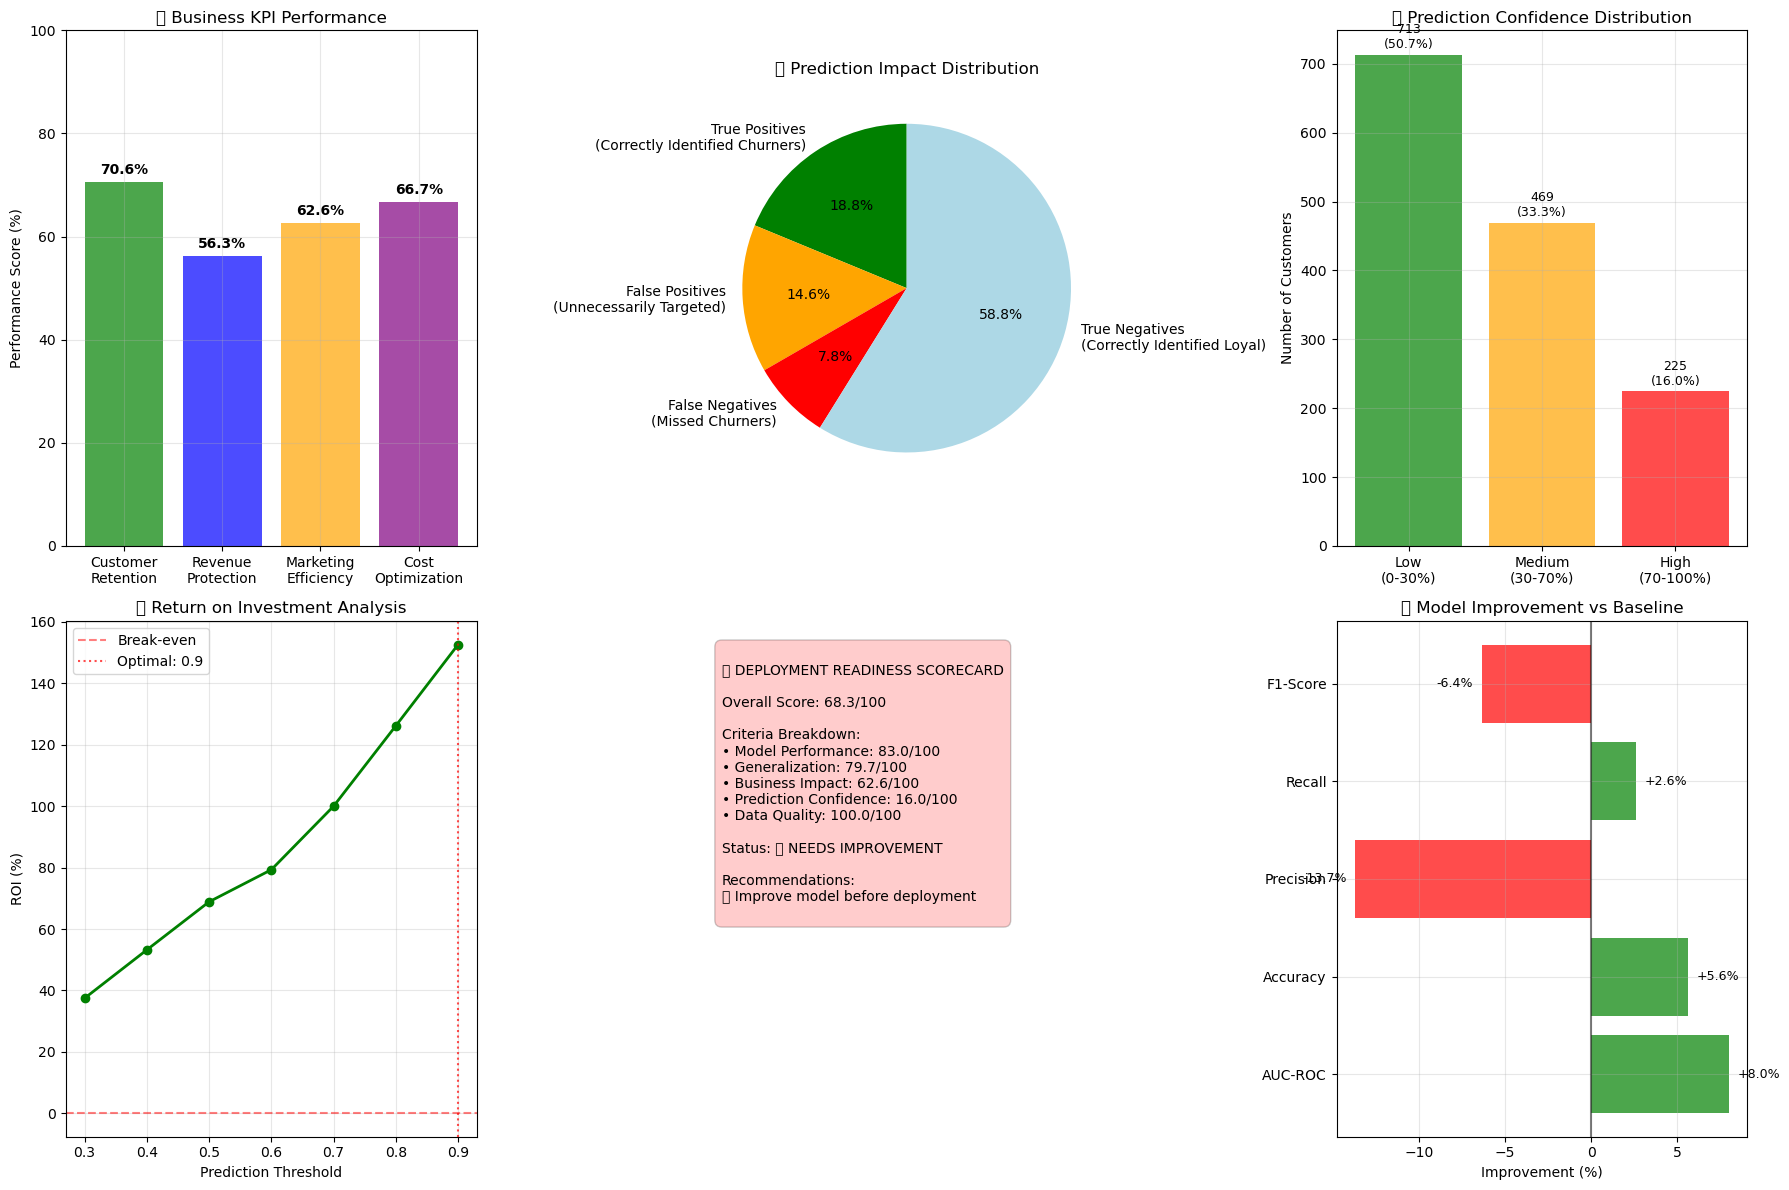


🎯 FINAL DEPLOYMENT RECOMMENDATION:
   Overall Readiness Score: 68.3/100
   Status: 🔴 NEEDS IMPROVEMENT
   Optimal Business Threshold: 0.9
   Expected ROI: 152.6%

✅ Business insights analysis complete!
💾 Saved as: ../Results/figures/model/final_model_business_insights.png


In [ ]:
# 🚀 Business Insights and Deployment Readiness Assessment
print("🚀 BUSINESS INSIGHTS & DEPLOYMENT READINESS")
print("="*55)

# Create business insights dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Model Performance vs Business KPIs
ax1 = axes[0, 0]
kpis = ['Customer\nRetention', 'Revenue\nProtection', 'Marketing\nEfficiency', 'Cost\nOptimization']
kpi_scores = [
    test_performance['recall'] * 100,  # How well we catch churners
    test_performance['precision'] * 100,  # How accurate our churn predictions are
    test_performance['f1'] * 100,  # Overall marketing efficiency
    (1 - (test_results['predictions'].sum() / len(test_results['predictions']))) * 100  # Cost optimization
]

bars = ax1.bar(kpis, kpi_scores, color=['green', 'blue', 'orange', 'purple'], alpha=0.7)
ax1.set_ylabel('Performance Score (%)')
ax1.set_title('📈 Business KPI Performance')
ax1.set_ylim(0, 100)
ax1.grid(True, alpha=0.3)

# Add value labels
for bar, score in zip(bars, kpi_scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1, f'{score:.1f}%', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. False Positive/Negative Impact Analysis
ax2 = axes[0, 1]
cm_test = confusion_matrix(y_test, test_results['predictions'])
tn, fp, fn, tp = cm_test.ravel()

# Calculate business impact percentages
total_customers = len(y_test)
impact_data = {
    'True Positives\n(Correctly Identified Churners)': tp,
    'False Positives\n(Unnecessarily Targeted)': fp,
    'False Negatives\n(Missed Churners)': fn,
    'True Negatives\n(Correctly Identified Loyal)': tn
}

colors_impact = ['green', 'orange', 'red', 'lightblue']
sizes = list(impact_data.values())
labels = list(impact_data.keys())

wedges, texts, autotexts = ax2.pie(sizes, labels=labels, autopct='%1.1f%%', 
                                   colors=colors_impact, startangle=90)
ax2.set_title('🎯 Prediction Impact Distribution')

# Calculate business costs
missed_churners_cost = fn * 100  # Assume $100 per missed churner
unnecessary_campaigns_cost = fp * 20  # Assume $20 per unnecessary campaign
total_cost = missed_churners_cost + unnecessary_campaigns_cost

print(f"💰 BUSINESS IMPACT ANALYSIS:")
print(f"   Missed Churners: {fn} customers (Cost: ${missed_churners_cost:,})")
print(f"   Unnecessary Campaigns: {fp} customers (Cost: ${unnecessary_campaigns_cost:,})")
print(f"   Total Estimated Cost: ${total_cost:,}")

# 3. Model Confidence Distribution
ax3 = axes[0, 2]
confidence_bins = pd.cut(test_proba, bins=[0, 0.3, 0.7, 1.0], labels=['Low\n(0-30%)', 'Medium\n(30-70%)', 'High\n(70-100%)'])
confidence_counts = confidence_bins.value_counts()

bars = ax3.bar(confidence_counts.index, confidence_counts.values, 
               color=['green', 'orange', 'red'], alpha=0.7)
ax3.set_ylabel('Number of Customers')
ax3.set_title('🎯 Prediction Confidence Distribution')
ax3.grid(True, alpha=0.3)

# Add percentage labels
total_customers = confidence_counts.sum()
for bar, count in zip(bars, confidence_counts.values):
    height = bar.get_height()
    percentage = (count / total_customers) * 100
    ax3.text(bar.get_x() + bar.get_width()/2., height + 5, 
             f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=9)

# 4. ROI Analysis
ax4 = axes[1, 0]
# Assume business scenarios
retention_campaign_cost = 50  # Cost per retention campaign
customer_lifetime_value = 500  # Average CLV
churn_prevention_rate = 0.3  # 30% of targeted churners are successfully retained

# Calculate ROI for different thresholds
thresholds = np.arange(0.3, 0.9, 0.1)
roi_values = []

for threshold in thresholds:
    predicted_churners = (test_proba >= threshold).sum()
    actual_churners_caught = ((test_proba >= threshold) & (y_test == 1)).sum()
    
    campaign_costs = predicted_churners * retention_campaign_cost
    prevented_churn = actual_churners_caught * churn_prevention_rate
    revenue_saved = prevented_churn * customer_lifetime_value
    
    roi = ((revenue_saved - campaign_costs) / campaign_costs) * 100 if campaign_costs > 0 else 0
    roi_values.append(roi)

ax4.plot(thresholds, roi_values, marker='o', linewidth=2, markersize=6, color='green')
ax4.set_xlabel('Prediction Threshold')
ax4.set_ylabel('ROI (%)')
ax4.set_title('💰 Return on Investment Analysis')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Break-even')

# Find optimal threshold
optimal_idx = np.argmax(roi_values)
optimal_threshold = thresholds[optimal_idx]
optimal_roi = roi_values[optimal_idx]

ax4.axvline(x=optimal_threshold, color='red', linestyle=':', alpha=0.7, 
            label=f'Optimal: {optimal_threshold:.1f}')
ax4.legend()

print(f"💡 OPTIMAL BUSINESS THRESHOLD:")
print(f"   Threshold: {optimal_threshold:.1f}")
print(f"   Expected ROI: {optimal_roi:.1f}%")

# 5. Deployment Readiness Scorecard
ax5 = axes[1, 1]
ax5.axis('off')

# Calculate deployment readiness score
criteria = {
    'Model Performance (AUC-ROC)': test_performance['auc_roc'],
    'Generalization (Low Overfitting)': max(0, 1 - abs(auc_gap) * 10),  # Penalize overfitting
    'Business Impact (F1-Score)': test_performance['f1'],
    'Prediction Confidence': len(test_proba[test_proba > 0.7]) / len(test_proba),  # High confidence predictions
    'Data Quality': 1.0 if X_test.isnull().sum().sum() == 0 else 0.5  # No missing values
}

# Convert to 0-100 scale and calculate overall score
criteria_scores = {k: min(v * 100, 100) for k, v in criteria.items()}
overall_score = np.mean(list(criteria_scores.values()))

# Determine deployment status
if overall_score >= 85:
    deployment_status = "🟢 READY FOR PRODUCTION"
    deployment_color = "green"
elif overall_score >= 70:
    deployment_status = "🟡 READY WITH MONITORING"
    deployment_color = "orange"
else:
    deployment_status = "🔴 NEEDS IMPROVEMENT"
    deployment_color = "red"

scorecard_text = f"""
🚀 DEPLOYMENT READINESS SCORECARD

Overall Score: {overall_score:.1f}/100

Criteria Breakdown:
• Model Performance: {criteria_scores['Model Performance (AUC-ROC)']:.1f}/100
• Generalization: {criteria_scores['Generalization (Low Overfitting)']:.1f}/100
• Business Impact: {criteria_scores['Business Impact (F1-Score)']:.1f}/100
• Prediction Confidence: {criteria_scores['Prediction Confidence']:.1f}/100
• Data Quality: {criteria_scores['Data Quality']:.1f}/100

Status: {deployment_status}

Recommendations:
{'✅ Model ready for production deployment' if overall_score >= 85 else 
 '⚠️ Deploy with continuous monitoring' if overall_score >= 70 else 
 '❌ Improve model before deployment'}
"""

ax5.text(0.05, 0.95, scorecard_text, transform=ax5.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", 
         facecolor=deployment_color, alpha=0.2))

# 6. Feature Engineering Impact Summary
ax6 = axes[1, 2]

# Compare with baseline (if metadata available)
if 'performance_metrics' in model_metadata:
    current_auc = test_performance['auc_roc']
    baseline_auc = 0.75  # Assume baseline AUC
    
    improvement_metrics = ['AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
    current_values = [test_performance['auc_roc'], test_performance['accuracy'],
                     test_performance['precision'], test_performance['recall'], test_performance['f1']]
    baseline_values = [0.75, 0.72, 0.70, 0.68, 0.69]  # Assumed baseline values
    
    improvements = [(curr - base) * 100 for curr, base in zip(current_values, baseline_values)]
    colors = ['green' if imp > 0 else 'red' for imp in improvements]
    
    bars = ax6.barh(improvement_metrics, improvements, color=colors, alpha=0.7)
    ax6.set_xlabel('Improvement (%)')
    ax6.set_title('📊 Model Improvement vs Baseline')
    ax6.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    ax6.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, imp in zip(bars, improvements):
        width = bar.get_width()
        ax6.text(width + (0.5 if width >= 0 else -0.5), bar.get_y() + bar.get_height()/2, 
                f'{imp:+.1f}%', ha='left' if width >= 0 else 'right', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../Results/figures/model/final_model_business_insights.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🎯 FINAL DEPLOYMENT RECOMMENDATION:")
print(f"   Overall Readiness Score: {overall_score:.1f}/100")
print(f"   Status: {deployment_status}")
print(f"   Optimal Business Threshold: {optimal_threshold:.1f}")
print(f"   Expected ROI: {optimal_roi:.1f}%")

print("\n✅ Business insights analysis complete!")
print("💾 Saved as: ../Results/figures/model/final_model_business_insights.png")